# Mountain Car

My work with LSPI + Mountain Car environment.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
plt.rcParams["figure.figsize"] = 10, 6

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import gym

from lspi.util import generate_sample_data

from lspi.policy import RandomPolicy, DiscreteActionBasisPolicy
from lspi.basis import IndActionPolyStateBasis, IndActionRBFStateBasis, QuadraticBasis

from lspi.optim import LSPI
from lspi.optim import LSTDQ

# Tools

#### close all env windows

In [ ]:
gym.core.env_closer.close()

# Mountain Car Discrete

In [ ]:
from lspi.util import DiscreteEnvWrapper, random_discretization, linear_discretization

env = gym.make("MountainCar-v0")

In [ ]:
from lspi.util import SampleGenerator

In [ ]:
env.action_space

In [ ]:
env.observation_space

### Quadratic Basis

In [ ]:
coefs = [
    np.eye(3),
    np.ones((3, 3)),
    np.array([[1,1,-1],[1,-1,1],[-1,1,1]])
]

In [ ]:
num_rollouts = 1000
num_steps = 6

In [ ]:
data = SampleGenerator(env, RandomPolicy(env)).sample(num_rollouts, num_steps)
basis = QuadraticBasis(coefs, env.action_space, env.observation_space)
lstdq = LSTDQ(basis, discount=0.95)
dabp = DiscreteActionBasisPolicy(env.action_space, basis, np.zeros(basis.rank))

In [ ]:
lspi = LSPI(lstdq, dabp, max_iter=50, epsilon=1e-3)
lspi.fit(data)

In [ ]:
lspi.itr_

In [ ]:
rewards = []
actions = []

for episode in range(100):
    state = env.reset()
    done = False
    cumr = 0
    while not done:
        action = lspi.policy(state)
        actions.append(action)
        state, reward, done, _ = env.step(action)
        cumr += reward
        env.render()
    rewards.append(cumr)
#         print("Action: {}, Reward: {}".format(action, reward))
#     print("Episode {episode}, Reward: {reward}".format(episode=episode, reward=reward))

In [ ]:
plt.hist(cumr)

### RBF Basis

In [ ]:
env = gym.make("MountainCar-v0")
env._max_episode_steps = 300

In [ ]:
num_rollouts = 600
num_steps = 20
data = SampleGenerator(env, RandomPolicy(env)).sample(num_rollouts, num_steps)

In [ ]:
len(data)

In [ ]:
from lspi.util import BoxAnchorGen

numAnchors = 40
anchors = BoxAnchorGen(numAnchors, env.observation_space)
basis = IndActionRBFStateBasis(anchors, env.action_space, env.observation_space)
dabp = DiscreteActionBasisPolicy(env.action_space, basis, np.zeros(basis.rank))

In [ ]:
lstdq = LSTDQ(basis, discount=0.95)
lspi = LSPI(lstdq, dabp, max_iter=25, epsilon=1e-3)
lspi.fit(data)

In [ ]:
lspi.itr_

In [ ]:
rewards = []
actions = []

for episode in range(50):
    state = env.reset()
    done = False
    cumr = 0
    while not done:
        action = lspi.policy(state)
        actions.append(action)
        state, reward, done, _ = env.step(action)
#         done = cumr < -300 or state[0] > 0.5
        cumr += reward
#         env.render()
#     print(cumr)
#         print("Action: {}, State: {}, Reward: {}".format(action, state, reward))
    rewards.append(cumr)
#     print("Episode {episode}, Reward: {reward}".format(episode=episode, reward=reward))

In [ ]:
plt.hist(actions)

In [ ]:
plt.hist(rewards)

# Mountain Car Continuous

In [8]:
from lspi.util import DiscreteEnvWrapper, random_discretization, linear_discretization

env = gym.make("MountainCarContinuous-v0")
actions = linear_discretization(env.action_space, n=6)
dEnv = DiscreteEnvWrapper(env, actions)
dEnv._actions

[2019-04-04 03:40:02,121] Making new env: MountainCarContinuous-v0


[array([-1.]),
 array([-0.6]),
 array([-0.2]),
 array([ 0.2]),
 array([ 0.6]),
 array([ 1.])]

In [11]:
from lspi.util import SampleGenerator
data = SampleGenerator(dEnv, RandomPolicy(dEnv)).sample(10, 6)

In [15]:
from lspi.basis import DiscreteQuadraticBasis

coefs = [
    np.eye(3),
    np.ones((3, 3)),
    np.array([[1,1,-1],[1,-1,1],[-1,1,1]])
]
basis = DiscreteQuadraticBasis(coefs, dEnv._actions, dEnv.observation_space)

In [39]:
basis(dEnv.observation_space.sample(), 0)

array([ 1.        ,  1.92783146,  3.73447137,  2.00178615])

In [40]:
lstdq = LSTDQ(basis, discount=0.95)
dabp = DiscreteActionBasisPolicy(dEnv.action_space, basis, np.zeros(basis.rank))

In [41]:
lspi = LSPI(lstdq, dabp, max_iter=50, epsilon=1e-3)
lspi.fit(data)

In [42]:
lspi.itr_

2

In [57]:
rewards = []
actions = []

for episode in range(50):
    state = env.reset()
    done = False
    cumr = 0
    while not done:
        action = lspi.policy(state)
        action = dEnv._actions[action]
        actions.append(action)
        state, reward, done, _ = env.step(action)
#         done = cumr < -300 or state[0] > 0.5
        cumr += reward
#         env.render()
#     print(cumr)
#         print("Action: {}, State: {}, Reward: {}".format(action, state, reward))
    rewards.append(cumr)
#     print("Episode {episode}, Reward: {reward}".format(episode=episode, reward=reward))
rewards = np.array(rewards)

(array([  1.,   1.,   1.,   3.,   4.,  13.,   0.,   0.,   1.,   5.,   1.,
         10.,   4.,   0.,   0.,   0.,   0.,   0.,   0.,   4.]),
 array([ 98.364 ,  98.3874,  98.4108,  98.4342,  98.4576,  98.481 ,
         98.5044,  98.5278,  98.5512,  98.5746,  98.598 ,  98.6214,
         98.6448,  98.6682,  98.6916,  98.715 ,  98.7384,  98.7618,
         98.7852,  98.8086,  98.832 ]),
 <a list of 20 Patch objects>)

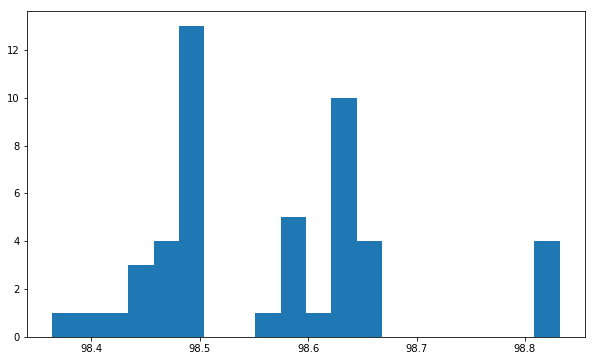

In [58]:
plt.hist(rewards[rewards > 50], bins=20)

# Rigorous Testing

OK.  So now we know we can actually solve this problem, and we'd like to
explore when this algorithm works and when it doesn't.  To figure out the
best way to go about this this testing, let's list what "knobs" we have
and what "dials" we're looking at:

Knobs:  
* rbf basis: anchor points + how many
* poly basis: order
* discount
* environment
* number of testing episodes
* data
    * quantity
    * distribution (random vs. educated policy)

Dials:  
* total reward
* total steps
* action distribution (since we're working in discrete this is p easy, could estimate some parametric dist. in continuous)


## initial thoughts

* we can sample from our observation space for new anchor points
    * however, since the env. puts a $(-\infty, \infty)$ bound on velocities this will result in poor anchors
    * I can get the bounds from a space and just "clip" them to reasonable amounts and create a new space
* if we want to examine rbf + poly, we need a composite basis.  just going to use RBF for now
* w/ reward + steps we can get avg. reward
* Id like a dictionary for each testing event, as then I can do post-processing in pandas

Now we can use this generator in place of previous anchor points.  Now lets
develop a framework for providing our inputs.  Not sure if some sort of 
object or simply a function makes more sense here.

In [ ]:
from lspi.policy import Policy

def run_test(policy, env, num_episodes = 100):
    numsteps = []
    action_ratio = []
    rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        steps = 0
        total_reward = 0
        actions = []
        while not done:
            action = policy(state)
            state, reward, done, _ = env.step(action)
            actions.append(action)
            total_reward += reward
            steps += 1
        rewards.append(total_reward)
        numsteps.append(steps)
        action_ratio.append(np.mean(actions))
        
    return {"steps": numsteps, "rewards": rewards, "action_ratio": action_ratio}

In [ ]:
results = run_test(lspi.policy, env, num_episodes=10)